In [1]:
from myai.imports import *
from visualbench.benchmark import Benchmark
from visualbench.dataset_tools import make_dataset_from_tensor
from visualbench.utils import CUDA_IF_AVAILABLE

In [21]:
class Dataset2D(Benchmark):
    """dataset with 2 variables for live training animation. x is (n_samples, 2) or (2, n_samples), y is n_samples, or (n_samples, 1)"""
    grid_points: torch.nn.Buffer
    mask: torch.nn.Buffer
    data: torch.nn.Buffer
    def __init__(self, x, y, model, loss_fn, batch_size=None, norm_x = False, norm_y = False, resolution=256, device = CUDA_IF_AVAILABLE, dtype=torch.float32):

        x = totensor(x, device=device, dtype=dtype).squeeze()
        if x.shape[0] == 2 and x.shape[1] > 2: x = x.T
        if x.ndim > 2 or x.shape[1] != 2: raise ValueError(f"{x.shape = }")
        # x is (n_samples, 2)

        y = totensor(y, device=device, dtype=dtype).squeeze()
        if y.ndim == 2 and y.shape[1] == 2: y = y.argmax(1)
        if y.ndim == 2 and y.shape[0] == 2: y = y.argmax(0)
        if y.ndim != 1: raise ValueError(f"{y.shape = }")
        y = y.unsqueeze(1)

        if norm_x:
            x = x - x.mean(0, keepdim=True)
            std = x.std(0, keepdim=True)
            std[std == 0] = 1
            x = x / std

        if norm_y:
            y = y - y.mean()
            y = y / y.std()

        data, _ = make_dataset_from_tensor((x, y), batch_size=batch_size)
        super().__init__(train_data=data, device = device)
        self.model = model
        self.loss_fn = loss_fn

        domain = totensor([
            [x[:, 0].min().detach().cpu().item() - 1, x[:, 1].min().detach().cpu().item() - 1],
            [x[:, 0].max().detach().cpu().item() + 1, x[:, 1].max().detach().cpu().item() + 1]], device=device,dtype=dtype)

        # grid of all possible samples
        x_lin = torch.linspace(domain[0][0], domain[1][0], resolution, device=device)
        y_lin = torch.linspace(domain[0][1], domain[1][1], resolution, device=device)
        xx, yy = torch.meshgrid(x_lin, y_lin, indexing="xy")
        grid_points = torch.stack((xx.ravel(), yy.ravel()), dim=1).float()

        # X_train in grid_points coords
        x_step = x_lin[1] - x_lin[0]
        y_step = y_lin[1] - y_lin[0]
        X_train_grid = ((x - domain[0]) / torch.stack((x_step, y_step))).round().int()

        # mask to quickly display dataset points on the image
        mask = torch.zeros((resolution, resolution), dtype = torch.bool, device = device)
        data = torch.zeros((resolution, resolution), dtype = torch.float32, device = device)
        data[*X_train_grid.T.flip(0)] = normalize(y.squeeze(), 0, 255)
        mask[*X_train_grid.T.flip(0)] = True

        self.register_buffer('grid_points', grid_points)
        self.register_buffer('mask', mask)
        self.register_buffer('data', data)
        self.resolution = resolution

    def get_loss(self):
        x, y = self.batch
        outputs = self.model(x)
        loss = self.loss_fn(outputs, y)

        self.model.eval()
        with torch.inference_mode():
            Z: torch.Tensor = (torch.sigmoid(self.model(self.grid_points)) * 255).reshape(self.resolution, self.resolution).unsqueeze(0).repeat((3,1,1))
            Z[0] = 255 - Z[0] # 0 is red, 1 is green
            Z[2] = 0
            Z = torch.where(self.mask, self.data, Z)

        return loss, {"image": Z.clamp(0, 255).to(torch.uint8)}

In [23]:
from myai.imports import *


from sklearn.datasets import make_moons
X, y = make_moons(n_samples=2048, noise=0.2, random_state=0)

# https://github.com/ClashLuke/HeavyBall/blob/main/benchmark/loss_contour.py

class Sine(nn.Module):
    def forward(self, x):
        return torch.sin(x)


class Residual(nn.Module):
    def __init__(self, wrapped):
        super().__init__()
        self.wrapped = wrapped

    def forward(self, x):
        return x + self.wrapped(x)

def beta_debias(beta, step):
    return 1 - (1 - beta) / (1 - beta ** step)


class DatasetNorm(nn.Module):
    def __init__(self, features: int, momentum: float = 0.99):
        super().__init__()
        self.weight = nn.Parameter(torch.stack([torch.ones(features), torch.zeros(features)], 1))
        self.register_buffer('stats', torch.zeros(features * 2))
        self.register_buffer('step', torch.tensor(0))
        self.momentum = momentum

    def forward(self, x):
        if True:
            with torch.no_grad():
                mean, sq_mean = x.mean(dim=0), (x ** 2).mean(dim=0)
                stats = torch.cat([mean, sq_mean])
                self.step.add_(1)
                self.stats.lerp_(stats, 1 - beta_debias(self.momentum, self.step))
                # self.stats.lerp_(stats, self.step == 1)
                mean, sq_mean = self.stats.chunk(2)
                std = (sq_mean - mean ** 2).clamp_min_(1e-6).sqrt()
        else:
            std, mean = 1, 0
        weight, bias = self.weight.unbind(1)
        return (x - mean) / std * weight + bias


class MLP(nn.Module):
    def __init__(self, in_shape, out_shape, width, depth, act=Sine(), expanded: int = 256):
        super(MLP, self).__init__()
        layers = []
        layers.append(nn.Linear(in_shape, width))

        for _ in range(depth - 1):
            layers.append(Residual(nn.Sequential(nn.Linear(width, expanded),  #
                                                 act,  #
                                                 DatasetNorm(expanded),  #
                                                 nn.Linear(expanded, width))))
        layers.append(DatasetNorm(width))
        layers.append(nn.Linear(width, out_shape))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


bench = Dataset2D(X, y, MLP(in_shape=2, out_shape=1, width=2, depth=3), loss_fn = torch.nn.BCEWithLogitsLoss(), norm_x=True, device = 'cpu')

In [24]:
bench.run(torch.optim.SGD(bench.parameters(), 1e-1), 10)

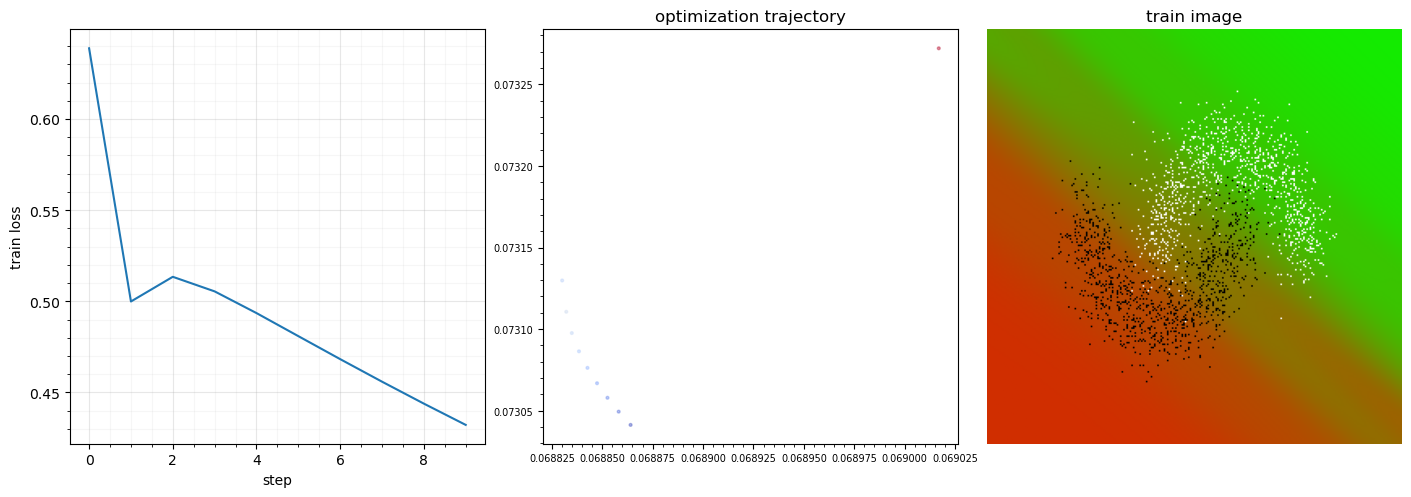

In [25]:
bench.plot_summary(nrows=1)

In [26]:
bench.render_video('bababa')

10/10 | 0.04s          
